In [1]:
### Set up
from itertools import product
import math
import numpy as np
from pathlib import Path
from plotnine import (
    ggplot,
    aes,
    theme, 
    element_text,
    stat_smooth,
    facet_wrap,
    geom_tile,
    geom_point,
    geom_histogram,
    geom_violin,
    geom_col,
    xlab,
    ylab,
    ggtitle,
    geom_line,
    geom_ribbon,
    geom_vline,
    geom_text
)
import polars as pl
import torch
import functorch


from sngrok.fourier import slow_ft_1d, slow_ft_2d, sn_fourier_basis, sn_fourier_basis_2d, calc_power
from sngrok.permutations import Permutation, make_permutation_dataset
from sngrok.model import SnMLP
from sngrok.tableau import generate_partitions
from sngrok.irreps import SnIrrep

In [2]:


def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    fourier_transform = slow_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, math.factorial(n))
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().numpy(), schema=[f'dim{i}' for i in range(256)])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform


def calc_power_contributions_2d(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    group_order = math.factorial(n)**2
    fourier_transform = slow_ft_2d(tensor, n)
    irrep_power = calc_power(fourier_transform, group_order)
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().cpu().numpy(), schema=[f'dim{i}' for i in range(256)])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform



def embedding_harmonic_analysis(checkpoint, config, epoch, lperms, rperms , targets, test_mask):
    #run = torch.load(checkpoint, map_location=torch.device('cpu'))
    model = SnMLP.from_config(config)
    model.load_state_dict(checkpoint)
    
    out, cache = model.run_with_cache(lperms[test_mask], rperms[test_mask])
    loss = loss_fn(out, targets[test_mask])
    
    lembed_power_df, lembed_fourier_transform = calc_power_contributions(
        model.lembed.weight, 5
    )
    lembed_power_df.insert_at_idx(0, pl.Series('layer', ['left_embed'] * lembed_power_df.shape[0]))
    rembed_power_df, rembed_fourier_transform = calc_power_contributions(
        model.rembed.weight, 5
    )
    rembed_power_df.insert_at_idx(0, pl.Series('layer', ['right_embed'] * lembed_power_df.shape[0]))
    epochs = pl.Series('epoch', [epoch] * lembed_power_df.shape[0])
    lembed_power_df.insert_at_idx(0, epochs)
    rembed_power_df.insert_at_idx(0, epochs)
    return (
        pl.concat([lembed_power_df, rembed_power_df], how='vertical'),
        loss
    )


def loss_fn(logits, labels):
    if len(logits.shape) == 3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])
    return -1. * correct_log_probs



In [3]:


def training_plot(run):
    
    model_run = torch.load(f'checkpoints/{run}/full_run.pth', map_location=torch.device('cpu'))
    ft_dir = ckpt_dir / f'{run}/harmonics/ft'
    ft_dir.mkdir(parents=True, exist_ok=True)

    embedding_data = []

    for ckpt, epoch in zip(model_run['checkpoints'], model_run['checkpoint_epochs']):
        data, ft_tensors =  embedding_harmonic_analysis(ckpt, model_run['config'], epoch)
        embedding_data.append(data)
        torch.save(ft_tensors, ft_dir / f'{epoch}.pth')
    
    embedding_run_df = pl.concat(embedding_data, how='vertical')
    embedding_run_df.write_parquet(f'checkpoints/{run}/harmonics/embed_power.parquet')
    run_power_summary = (
        embedding_run_df
        .melt(id_vars=['epoch', 'layer', 'irrep'])
        .groupby(['epoch', 'layer', 'irrep'])
        .agg([
            pl.col('value').mean().alias('mean_power'),
            pl.col('value').quantile(0.25).alias('q25'),
            pl.col('value').quantile(0.75).alias('q75')
        ])
        .sort(['epoch', 'layer', 'irrep'])
    )
    plot = (
        ggplot(run_power_summary, aes(x='epoch', color='irrep'))
        + geom_line(aes(y='mean_power'))
        #+ scale_x_log10()
        + geom_ribbon(aes(ymin='q25', ymax='q75', fill='irrep'), alpha=0.5) 
        + facet_wrap('~layer')
        + theme(axis_text_x=element_text(rotation=30, hjust=1), figure_size=(16, 8))
        + xlab('Epoch') + ylab('Mean Proportion of Squared Norm')
        + ggtitle(f'Evolution of Sn Embeddings by Irreps: {run}')
    )
    plot.save(f'plots/embed_power/{run}.png')
    
    
def rank_irreps(data):
    df_groups = []
    for name, df in data.groupby(['epoch', 'layer']):
        df_groups.append(df.with_columns(pl.col('median_power').rank().alias('rank')))

    ranked_df = pl.concat(df_groups)
    ranked_df = ranked_df.sort(['epoch', 'rank'])
    return ranked_df



def make_rank_plot(data, run):
    
    plot = (
        ggplot(data, aes(x='test_loss', y='mean_power', color='factor(rank)'))
        + geom_line()
        #+ scale_x_log10()
        + geom_ribbon(aes(ymin='q25', ymax='q75', fill='factor(rank)'), alpha=0.5)
        + scale_x_reverse()
        + facet_wrap('~peak_group+layer')
        + theme(figure_size=(24, 16))
        + xlab('Test Loss') + ylab('Mean Proportion of Squared Norm')
        #+ geom_vline(xintercept=[2000, 19000], size=1.5)
        #+ geom_text(x=2100, y=0.4, color='black', label='Max Test loss', ha='left')
        #+ geom_text(x=19000, y=0.6, color='black', label='Test loss = 1', ha='right')
        + ggtitle(f'Rank of Sn Irreps as Grokking Happens: {run}')
    )
    return plot

    
def rank_training_plot(run, checkpoint_dir):
    run_dir = checkpoint_dir / run
    model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    data = pl.read_parquet(run_dir / 'data.parquet')
    mask = torch.asarray(~ data['in_train'].cast(pl.Boolean).to_numpy())
    lperms = torch.as_tensor(data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()

    #ft_dir = ckpt_dir / f'{run}/harmonics/ft'
    #ft_dir.mkdir(parents=True, exist_ok=True)

    embedding_data = []
    losses = []
    num_checkpoints = len(model_run['checkpoints'])
    for ckpt, epoch in zip(model_run['checkpoints'], model_run['checkpoint_epochs']):
        data, loss =  embedding_harmonic_analysis(ckpt, model_run['config'], epoch, lperms, rperms, targets, mask)
        embedding_data.append(data)
        losses.append(loss.mean().item())
        #torch.save(ft_tensors, ft_dir / f'{epoch}.pth')
    
    linear_run_df = pl.concat(embedding_data, how='vertical')
    loss_df = pl.DataFrame({'epoch': model_run['checkpoint_epochs'][:num_checkpoints], 'test_loss': losses})
    peaks = loss_df['test_loss'].peak_max().arg_true()
    if len(peaks) == 1:
        peak_idx = peaks.item()
    else:
        print(loss_df['test_loss'][peaks])
        peak_idx = peaks[0]
    peak_epoch = model_run['checkpoint_epochs'][peak_idx]
    loss_df = loss_df.with_columns(pl.col('epoch').apply(lambda x: 'before_peak' if x <= peak_epoch else 'after_peak').alias('peak_group'))
    #embedding_run_df.write_parquet(f'checkpoints/{run}/harmonics/embed_power.parquet')
    run_power_summary = (
        linear_run_df
        .melt(id_vars=['epoch', 'layer', 'irrep'])
        .groupby(['epoch', 'layer', 'irrep'])
        .agg([
            pl.col('value').mean().alias('mean_power'),
            pl.col('value').median().alias('median_power'),
            pl.col('value').quantile(0.25).alias('q25'),
            pl.col('value').quantile(0.75).alias('q75'),
            pl.col('value').quantile(0.05).alias('q05'),
            pl.col('value').quantile(0.95).alias('q95')
        ])
        .sort(['epoch', 'layer', 'irrep'])
    )
    all_data = rank_irreps(run_power_summary.join(loss_df, on='epoch', how='inner'))
    
    plot = make_rank_plot(all_data, run)
    plot.save(f'plots/irrep_rank/{run}.png')
    
    
    


In [41]:
ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/checkpoints')
rank_training_plot('s5_50_1', ckpt_dir)

/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 24 x 8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/irrep_rank/s5_50_1.png


In [4]:
from plotnine import scale_x_reverse


In [5]:
runs = [
    's5_50_0',
    's5_50_1',
    's5_50_2',
    's5_50_3',
    's5_50_4',
    's5_50_5',
    's5_50_6',
    's5_50_7',
    's5_50_8',
    's5_50_9',
    's5_50_11',
    's5_50_12',
    's5_50_13',
    's5_50_14',
    's5_50_15',
    's5_50_19',
    's5_50_20',
    's5_50_21',
    's5_50_22',
    's5_50_23'
]
ckpt_dir = Path('checkpoints')
print(ckpt_dir.exists())
for run in runs:
    pass
    #rank_training_plot(run, ckpt_dir)

True


In [6]:
all_partitions = generate_partitions(5)
partition_pairs = [f'{p}|{q}' for p, q in product(all_partitions, all_partitions)]

In [7]:
import functorch

batch_cov = functorch.vmap(torch.cov, in_dims=(0,))


irreps = [
    "(3, 2)|(3, 2)",
    "(4, 1)|(4, 1)",
    "(4, 1)|(3, 2)",
    "(3, 2)|(4, 1)",
    "(4, 1)|(5,)",
    "(5,)|(4, 1)",
    "(3, 2)|(1, 1, 1, 1, 1)",
    "(1, 1, 1, 1, 1)|(3, 2)",
    "(4, 1)|(1, 1, 1, 1, 1)",
    "(1, 1, 1, 1, 1)|(4, 1)",
    "(5,)|(5,)",
    "(5,)|(1, 1, 1, 1, 1)",
    "(1, 1, 1, 1, 1)|(5,)"
    "(5,)|((3, 2)",
    "(3, 2)|(5,)"
]

#cov_df = pl.DataFrame(torch.cov(linear_ft_decomp[1009]).detach().cpu().numpy(), schema=partition_pairs)
#cov_df.insert_at_idx(0, pl.Series('irrep_left', partition_pairs))
#df = cov_df.melt(id_vars='irrep_left', variable_name='irrep_right').filter(
    #pl.col('irrep_left').is_in(irreps) & pl.col('irrep_right').is_in(irreps)

#)

#(ggplot(df, aes(x='irrep_left', y='irrep_right', fill='value')) 
#    + geom_tile()
#    + theme(
#        axis_text_x=element_text(rotation=30, hjust=1),
#        axis_text_y=element_text(rotation=30, vjust=1),
#        figure_size=(16, 16))
#)

full_run = torch.load(ckpt_dir / 's5_50_9_fourier.pth')
list(full_run.keys())

['ft', 'ft_decomp', 'loss']

In [8]:
epochs = [0, 2, 4, 8, 16, 32, 64, 128, 256, 512]
epochs += list(range(1000, 25000, 1000))


In [10]:

from tqdm.notebook import tqdm

#all_covs = batch_cov(full_run['ft_decomp'][-1]).detach().cpu()


def get_cov_df(covariances, epoch):
    data = []
    for i, cov in enumerate(covariances):
        assert cov.shape == (49, 49)
        cov_df = pl.DataFrame(cov.tril().to(torch.float32).numpy(), schema=partition_pairs)
        cov_df.insert_at_idx(0, pl.Series('irrep_left', partition_pairs))
        cov_df = cov_df.melt(id_vars='irrep_left', variable_name='irrep_right')
        cov_df.insert_at_idx(0, pl.Series('index', [i]*cov_df.shape[0]))
        data.append(cov_df.filter(pl.col('value') != 0.0))
    all_data = pl.concat(data, how='vertical')
    all_data.insert_at_idx(0, pl.Series('epoch', [epoch]*all_data.shape[0]))
    all_data = all_data.lazy()
    
    return (all_data
             #.filter(pl.col('irrep_left').is_in(irreps) & pl.col('irrep_right').is_in(irreps))
             .groupby(['epoch', 'irrep_left', 'irrep_right'])
             .agg([
                 pl.col('value').mean().alias('mean_corr'),
                 pl.col('value').median().alias('median_corr'),
                 pl.col('value').quantile(0.25).alias('corr25'),
                 pl.col('value').quantile(0.75).alias('corr75'),
                 pl.col('value').min().alias('min_corr'),
                 pl.col('value').max().alias('max_corr')
             ])
             .sort('median_corr')
            ).collect()



all_data = []
for epoch, ft_decomp in tqdm(zip(epochs, full_run['ft_decomp'])):
    all_data.append(get_cov_df(batch_cov(ft_decomp).detach().cpu(), epoch))
    
    

0it [00:00, ?it/s]

In [11]:
all_data = pl.concat(all_data, how='vertical')

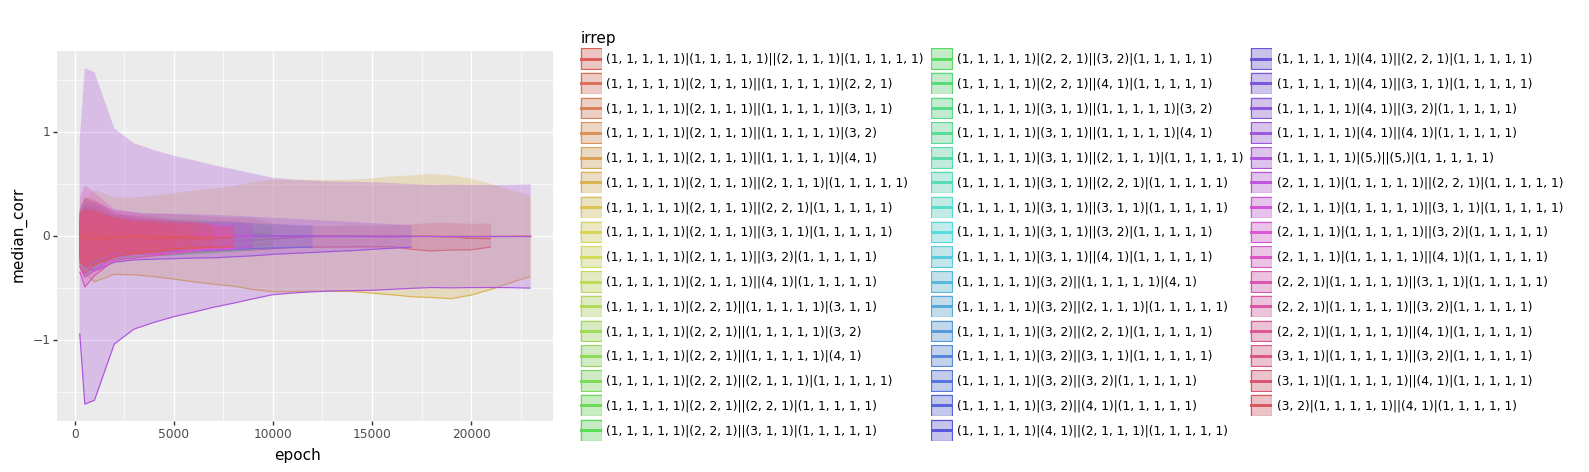

<ggplot: (1453008380)>

In [32]:
from plotnine import scale_color_discrete, scale_color_continuous

df = (all_data
      .filter(pl.col('irrep_left') != pl.col('irrep_right'))
      .filter((pl.col('corr75') > 0.1) | (pl.col('corr25') < -0.1))
      .with_columns((pl.col('irrep_left') + '||' + pl.col('irrep_right')).alias('irrep'))
)
      
      

(
    ggplot(
        df,
        aes(x='epoch', y='median_corr', fill='irrep', color='irrep')
    ) 
    + geom_line()
    + geom_ribbon(aes(ymin='corr25', ymax='corr75', fill='irrep'), alpha=0.3)
   
)

In [34]:
df.sort(['epoch', 'corr25']).filter((pl.col('corr75') > 0.5) | (pl.col('corr25') < -0.5))

epoch,irrep_left,irrep_right,mean_corr,median_corr,corr25,corr75,min_corr,max_corr,irrep
i64,str,str,f32,f32,f32,f32,f32,f32,str
256,"""(1, 1, 1, 1, 1...","""(5,)|(1, 1, 1,...",-8.2784e-12,0.0,-0.932606,0.932606,-0.932606,0.932606,"""(1, 1, 1, 1, 1..."
512,"""(1, 1, 1, 1, 1...","""(5,)|(1, 1, 1,...",-4.9671e-11,0.0,-1.612902,1.612902,-1.612902,1.612902,"""(1, 1, 1, 1, 1..."
1000,"""(1, 1, 1, 1, 1...","""(5,)|(1, 1, 1,...",4.9671e-11,0.0,-1.574808,1.574808,-1.574808,1.574808,"""(1, 1, 1, 1, 1..."
2000,"""(1, 1, 1, 1, 1...","""(5,)|(1, 1, 1,...",6.6227e-11,0.0,-1.034744,1.034744,-1.034744,1.034744,"""(1, 1, 1, 1, 1..."
3000,"""(1, 1, 1, 1, 1...","""(5,)|(1, 1, 1,...",-1.2418e-10,0.0,-0.89127,0.89127,-0.89127,0.89127,"""(1, 1, 1, 1, 1..."
4000,"""(1, 1, 1, 1, 1...","""(5,)|(1, 1, 1,...",8.2784e-12,0.0,-0.82719,0.82719,-0.82719,0.82719,"""(1, 1, 1, 1, 1..."
5000,"""(1, 1, 1, 1, 1...","""(5,)|(1, 1, 1,...",-2.4835e-11,0.0,-0.772608,0.772608,-0.772608,0.772608,"""(1, 1, 1, 1, 1..."
6000,"""(1, 1, 1, 1, 1...","""(5,)|(1, 1, 1,...",3.3114e-11,0.0,-0.729072,0.729072,-0.729072,0.729072,"""(1, 1, 1, 1, 1..."
7000,"""(1, 1, 1, 1, 1...","""(5,)|(1, 1, 1,...",1.5729e-10,0.0,-0.682388,0.682388,-0.682388,0.682388,"""(1, 1, 1, 1, 1..."


In [73]:
cov_df = pl.DataFrame(torch.cov(linear_ft_decomp[532]).numpy(), schema=partition_pairs)
cov_df.insert_at_idx(0, pl.Series('irrep_left', partition_pairs))



irrep_left,irrep_right,value
str,str,f64
"""(4, 1)|(1, 1, ...","""(1, 1, 1, 1, 1...",-0.250157
"""(1, 1, 1, 1, 1...","""(4, 1)|(1, 1, ...",-0.250157


In [87]:
cov532 = torch.cov(linear_ft_decomp[532])
torch.take(cov532, ).shape

torch.Size([2, 1176])

tensor([ 4.1488e-05,  4.1488e-05,  4.1488e-05,  ..., -3.8292e-12,
        -2.4677e-10, -3.8292e-12], dtype=torch.float64)

In [97]:
cov532[torch.triu_indices(49, 49, 1)]

torch.Size([2, 1176, 49])

In [12]:
data = pl.read_parquet(ckpt_dir / f's5_50_23/data.parquet')

In [13]:
sn_split = data.partition_by('in_train', as_dict=True)
train_lperms = torch.as_tensor(sn_split[1].select('index_left').to_numpy(), dtype=torch.int64)
train_rperms = torch.as_tensor(sn_split[1].select('index_right').to_numpy(), dtype=torch.int64)
train_targets = torch.as_tensor(sn_split[1].select('index_target').to_numpy(), dtype=torch.int64)
test_lperms = torch.as_tensor(sn_split[0].select('index_left').to_numpy(), dtype=torch.int64).squeeze()
test_rperms = torch.as_tensor(sn_split[0].select('index_right').to_numpy(), dtype=torch.int64).squeeze()
test_targets = torch.as_tensor(sn_split[0].select('index_target').to_numpy(), dtype=torch.int64).squeeze()

In [8]:
( ~ data['in_train'].cast(pl.Boolean).to_numpy()).shape

(14400,)

In [5]:


def mlp_harmonic_analysis(checkpoint, config, epoch, lperms, rperms, targets, test_mask):
    #x, y = torch.cartesian_prod(torch.arange(0, 120), torch.arange(0, 120)).hsplit(2)
    #x, y = x.squeeze(), y.squeeze()
    #run = torch.load(checkpoint, map_location=torch.device('cpu'))
    model = SnMLP.from_config(config)
    model.load_state_dict(checkpoint)
    model
    
    out, cache = model.run_with_cache(lperms[test_mask], rperms[test_mask])
    loss = loss_fn(out, targets)    
    linear_acts = cache['hook_linear'].to(torch.float32)
    linear_power_df, linear_fourier_transform = calc_power_contributions_2d(
        linear_acts.to('cuda'), 5
    )
    linear_power_df.insert_at_idx(0, pl.Series('layer', ['linear'] * linear_power_df.shape[0]))
    linear_power_df.insert_at_idx(0, pl.Series('epoch', [epoch] * linear_power_df.shape[0]))
    return (
        linear_power_df,
        linear_fourier_transform,
        loss
    )


def calc_power_contributions_2d(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    group_order = math.factorial(n)**2
    fourier_transform = slow_ft_2d(tensor, n)
    irrep_power = calc_power(fourier_transform, group_order)
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    
    val_data = pl.DataFrame(
        power_vals.detach().cpu().numpy(),
        schema=[f'dim{i}' for i in range(power_vals.shape[1])]
    )
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform

In [79]:
lperms = torch.as_tensor(data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
rperms = torch.as_tensor(data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
targets = torch.as_tensor(data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()


In [80]:
checkpoint = model_run['checkpoints'][-1]
config = model_run['config']
epoch = model_run['checkpoint_epochs'][-1]
mask = torch.asarray(~ data['in_train'].cast(pl.Boolean).to_numpy())
#df, ft, loss = mlp_harmonic_analysis(checkpoint, config, epoch, lperms, rperms, targets, mask)


In [120]:
data, losses = training_plot('s5_50_22', ckpt_dir)

In [89]:
losses

[4.822213764896751,
 4.840055778923469,
 4.85998848247672,
 4.904676872868473,
 5.012977275221929,
 5.315088752727883,
 6.259216600920305,
 8.461435126533125,
 19.016272585397488,
 24.710321497441708,
 28.240615846877322,
 24.22870053075507,
 21.78914583768123,
 19.911882310486444,
 18.265061235902387,
 16.759660615124666,
 15.210844589682136,
 13.828564911710147,
 12.474646055532425,
 11.143116296291565,
 9.667551246559304,
 7.9880907309714875,
 6.451594628841833,
 5.205253698046947,
 4.103351381309944,
 2.99470291391421,
 1.9490110379429864,
 1.0128441735307239,
 0.2755121560351896,
 0.02887038992980363,
 0.0012768840225298595,
 8.488288001990347e-05,
 1.4568655280826933e-05]

In [112]:
nploss = np.asarray(losses)
ls = pl.Series('loss', losses)

loss
f64


In [97]:
model_run['checkpoint_epochs'][27]

19000

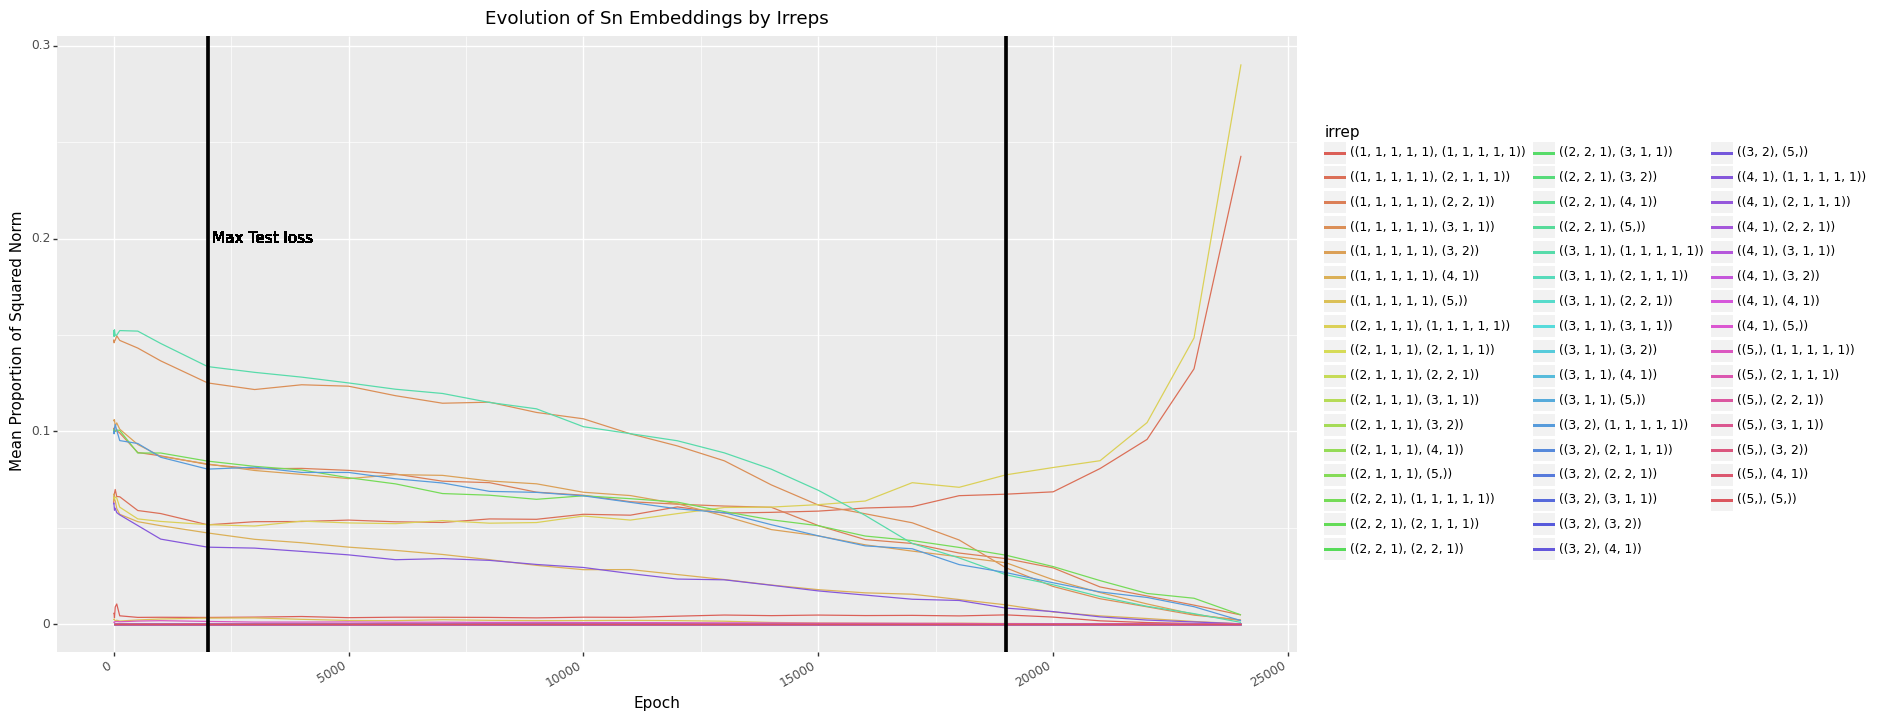

<ggplot: (8771321321908)>

In [121]:


(
        ggplot(data, aes(x='epoch', color='irrep'))
        + geom_line(aes(y='median_power'))
        #+ scale_x_log10()
        #+ geom_ribbon(aes(ymin='q25', ymax='q75', fill='irrep'), alpha=0.5) 
    
        + theme(axis_text_x=element_text(rotation=30, hjust=1), figure_size=(16, 8))
        + xlab('Epoch') + ylab('Mean Proportion of Squared Norm')
        + geom_vline(xintercept=[2000, 19000], size=1.5)
        + geom_text(x=2100, y=0.2, color='black', label='Max Test loss', ha='left')
        + ggtitle(f'Evolution of Sn Embeddings by Irreps')
    )

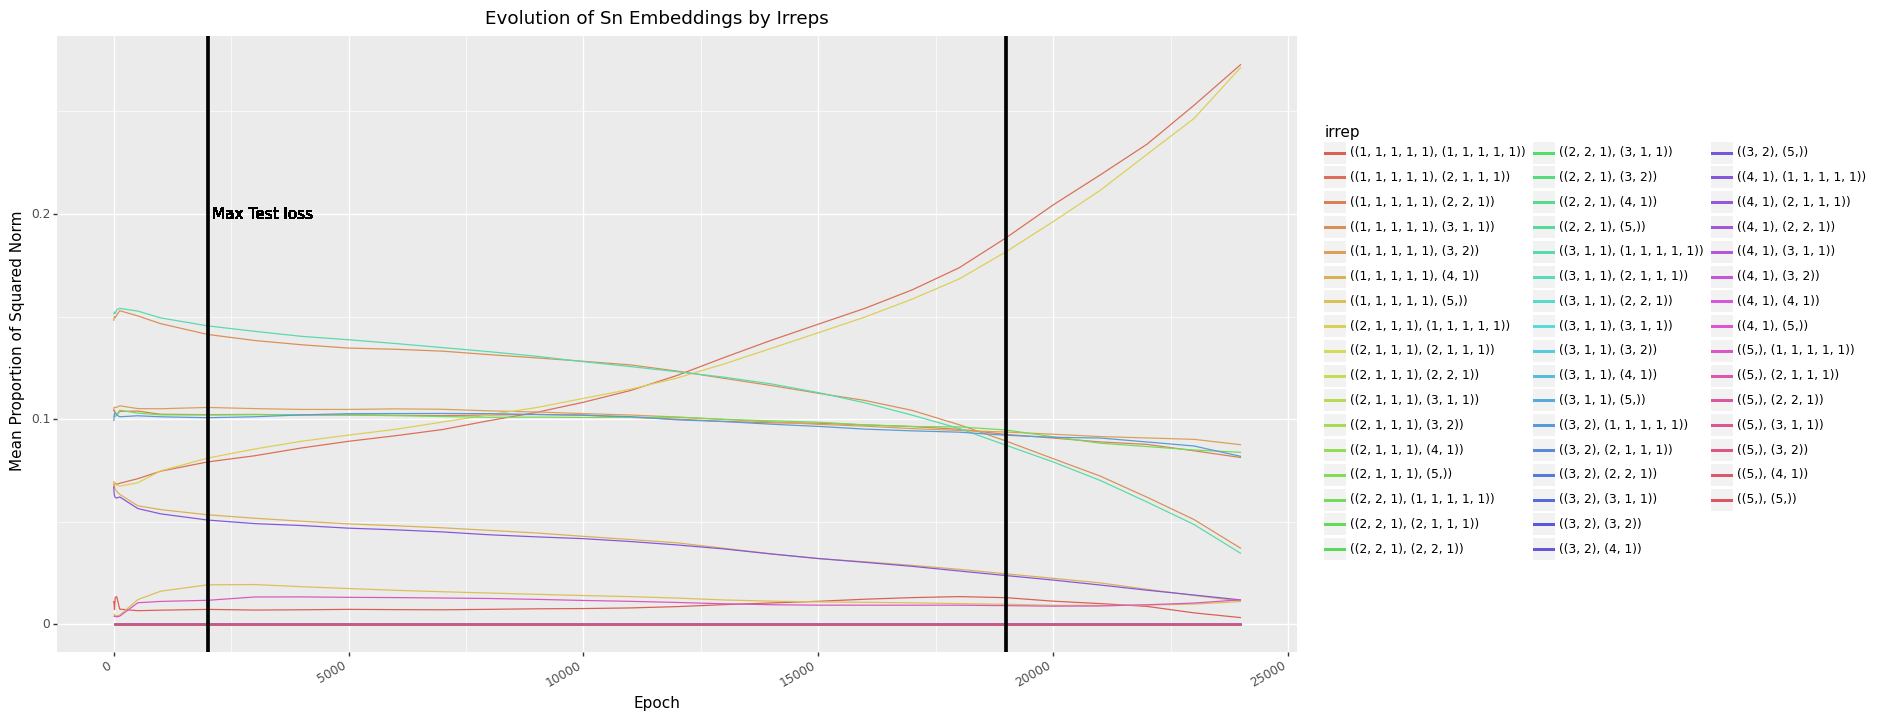

<ggplot: (8771319300973)>

In [122]:
(
        ggplot(data, aes(x='epoch', color='irrep'))
        + geom_line(aes(y='mean_power'))
        #+ scale_x_log10()
        #+ geom_ribbon(aes(ymin='q25', ymax='q75', fill='irrep'), alpha=0.5) 
    
        + theme(axis_text_x=element_text(rotation=30, hjust=1), figure_size=(16, 8))
        + xlab('Epoch') + ylab('Mean Proportion of Squared Norm')
        + geom_vline(xintercept=[2000, 19000], size=1.5)
        + geom_text(x=2100, y=0.2, color='black', label='Max Test loss', ha='left')
        + ggtitle(f'Evolution of Sn Embeddings by Irreps')
    )

In [15]:
from plotnine import geom_vline, geom_text




def training_plot(run, checkpoint_dir):
    run_dir = checkpoint_dir / run
    model_run = torch.load(run_dir / 'full_run.pth')
    data = pl.read_parquet(run_dir / 'data.parquet')
    mask = torch.asarray(~ data['in_train'].cast(pl.Boolean).to_numpy())
    lperms = torch.as_tensor(data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()
    #ft_dir = ckpt_dir / f'{run}/harmonics/ft'
    #ft_dir.mkdir(parents=True, exist_ok=True)

    embedding_data = []
    epoch_losses = []
    for ckpt, epoch in zip(model_run['checkpoints'], model_run['checkpoint_epochs']):
        data, loss =  embedding_harmonic_analysis(ckpt, model_run['config'], epoch, lperms, rperms, targets, mask)
        epoch_losses.append(loss.mean().item())
        embedding_data.append(data)
        #torch.save(ft_tensors, ft_dir / f'{epoch}.pth')
    
    epochs = data['epoch'].unique().to_list()
    loss_df = pl.DataFrame({'epoch': epochs, 'loss': losses})
    
    embedding_run_df = pl.concat(embedding_data, how='vertical')
    #embedding_run_df.write_parquet(f'checkpoints/{run}/harmonics/embed_power.parquet')
    run_power_summary = (
        embedding_run_df
        .melt(id_vars=['epoch', 'layer', 'irrep'])
        .groupby(['epoch', 'layer', 'irrep'])
        .agg([
            pl.col('value').mean().alias('mean_power'),
            pl.col('value').quantile(0.25).alias('q25'),
            pl.col('value').quantile(0.75).alias('q75')
        ])
        .sort(['epoch', 'layer', 'irrep'])
    )
    return run_power_summary, epoch_losses
    #plot.save(f'plots/embed_power/{run}.png')


In [16]:
data, losses = training_plot('s5_50_22', ckpt_dir)

In [29]:
epochs = data['epoch'].unique().to_list()
loss_df = pl.DataFrame({'epoch': epochs, 'loss': losses})
data = data.join(loss_df, on='epoch')

TypeError: Expr.rank() got an unexpected keyword argument 'descending'

In [45]:
data['loss'].max()

28.240615846877322

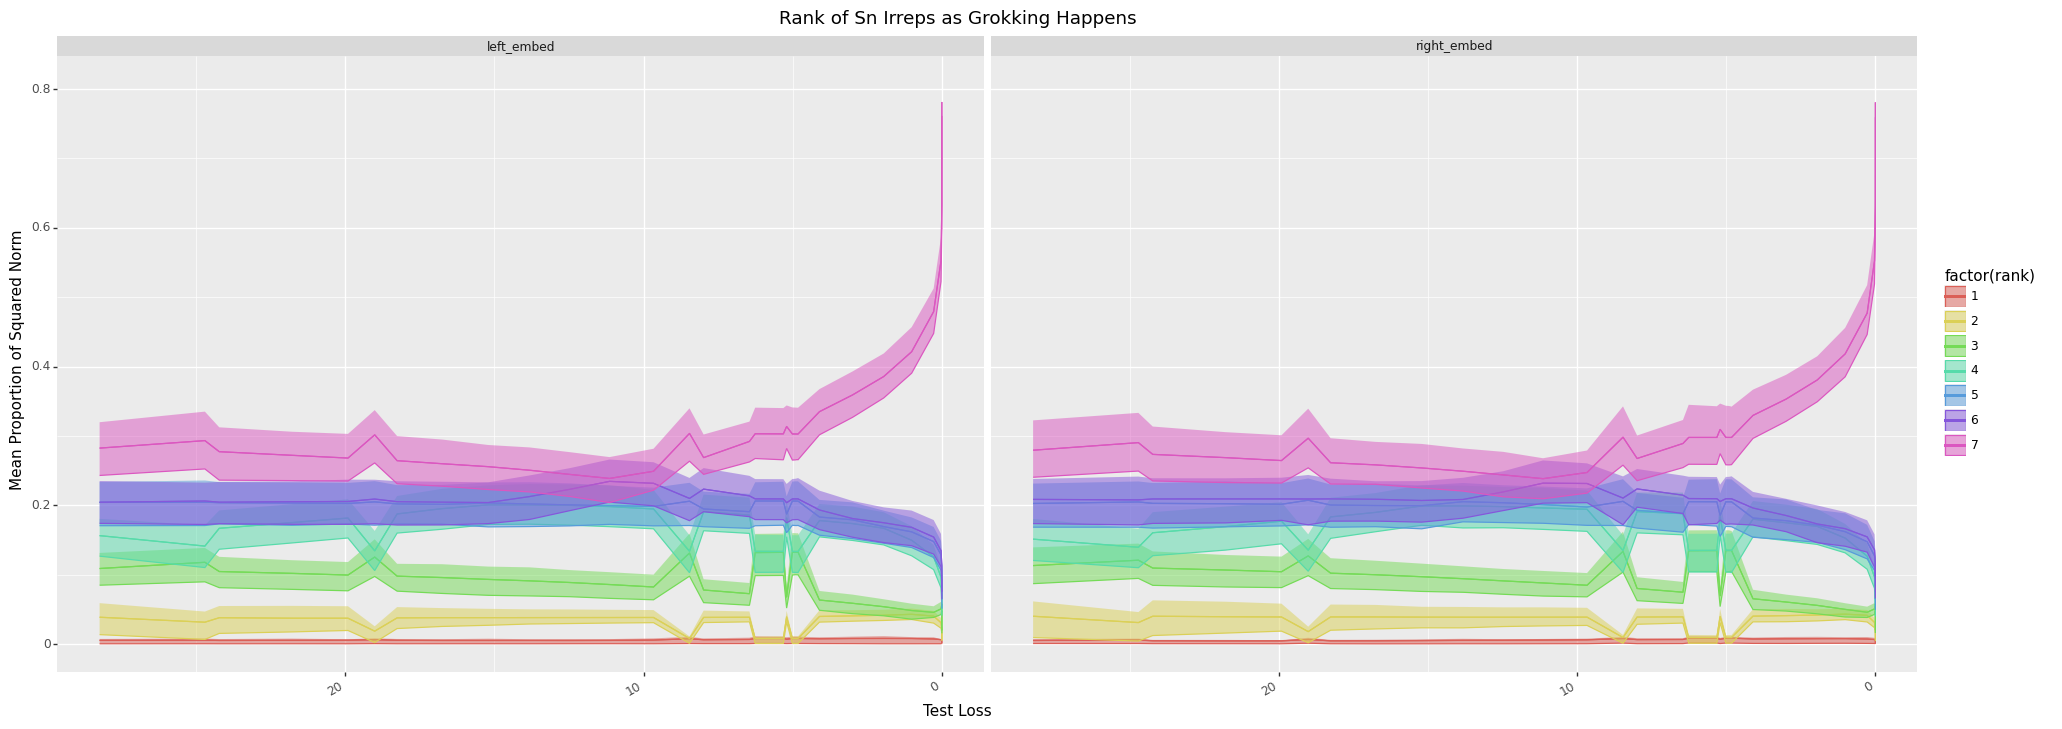

<ggplot: (8728021908009)>

In [47]:
ranked_df.filter(pl.col('epoch') < 2100)

epoch,layer,irrep,mean_power,q25,q75,loss,rank
i64,str,str,f32,f32,f32,f64,f32
0,"""left_embed""","""(1, 1, 1, 1, 1...",0.00804,0.000838,0.01072,4.822214,1.0
0,"""right_embed""","""(1, 1, 1, 1, 1...",0.008489,0.001452,0.010579,4.822214,1.0
0,"""left_embed""","""(5,)""",0.008065,0.000839,0.011111,4.822214,2.0
0,"""right_embed""","""(5,)""",0.009486,0.001288,0.013089,4.822214,2.0
0,"""left_embed""","""(4, 1)""",0.132485,0.099807,0.159856,4.822214,3.0
0,"""right_embed""","""(4, 1)""",0.134793,0.104725,0.163053,4.822214,3.0
0,"""left_embed""","""(2, 1, 1, 1)""",0.133455,0.103192,0.156864,4.822214,4.0
0,"""right_embed""","""(2, 1, 1, 1)""",0.135121,0.103108,0.159787,4.822214,4.0
0,"""left_embed""","""(3, 2)""",0.206065,0.170977,0.234456,4.822214,5.0


In [ ]:



def slow_ft_2d(fn_vals, n):
    all_partitions = generate_partitions(n)
    all_irreps = [SnIrrep(n, p) for p in all_partitions]
    results = {}
    for lirrep, rirrep in product(all_irreps, all_irreps):
        mats1, mats2 = zip(
            *product(
                lirrep.matrix_tensor().split(1),
                rirrep.matrix_tensor().split(1))
        )
        mats = batch_kron(
                torch.cat(mats1).squeeze().to(fn_vals.device),
                torch.cat(mats2).squeeze().to(fn_vals.device)
        )
        results[(lirrep.shape, rirrep.shape)] = fft_sum(fn_vals, mats.to(torch.float32)).squeeze()
    return results

In [ ]:
irreps = [
    "(3, 2)|(3, 2)",
    "(4, 1)|(4, 1)",
    "(4, 1)|(3, 2)",
    "(3, 2)|(4, 1)",
    "(4, 1)|(5,)",
    "(5,)|(4, 1)",
    "(3, 2)|(1, 1, 1, 1, 1)",
    "(1, 1, 1, 1, 1)|(3, 2)",
    "(4, 1)|(1, 1, 1, 1, 1)",
    "(1, 1, 1, 1, 1)|(4, 1)",
    "(5,)|(5,)",
    "(5,)|(1, 1, 1, 1, 1)",
    "(1, 1, 1, 1, 1)|(5,)"
    "(5,)|((3, 2)",
    "(3, 2)|(5,)"
]



def _calc(checkpoint, config, epoch, lperms, rperms, targets, test_mask):
    
    model = SnMLP.from_config(config)
    model.load_state_dict(checkpoint)
    out, cache = model.run_with_cache(lperms, rperms)
    loss = loss_fn(out[test_mask], targets[test_mask])
    
    tensor = cache['hook_linear'].to('cuda')
    
    linear_ft = {k: v.to(torch.float32) for k, v in slow_ft_2d(tensor, 5).items()}
    ft_decomp = sn_fourier_basis_2d(linear_ft, 5, 'cuda')
    return linear_ft, ft_decomp, loss
    


def calc_fourier(run, checkpoint_dir):
    run_dir = checkpoint_dir / run
    model_run = torch.load(run_dir / 'full_run.pth')
    
    data = pl.read_parquet(run_dir / 'data.parquet')
    mask = torch.asarray(~ data['in_train'].cast(pl.Boolean).to_numpy())
    lperms = torch.as_tensor(data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()
    fourier_transforms = []
    fourier_decomps = []
    epoch_losses = []
    for ckpt, epoch in zip(model_run['checkpoints'], model_run['checkpoint_epochs']):
        ft, ft_decomp, loss =  _calc(ckpt, model_run['config'], epoch, lperms, rperms, targets, mask)
        epoch_losses.append(loss.mean().item())
        fourier_transforms = {k: v.detach().to('cpu') for k, v in ft.items()}
        fourier_decomps.append(ft_decomp.detach().to('cpu'))
        #torch.save(ft_tensors, ft_dir / f'{epoch}.pth')
    return fourier_transforms, fourier_decomps, losses
    

    
transforms, decomps, losses = calc_fourier('s5_50_22', ckpt_dir)
    
    
